In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Assignment 2

### Importing packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

### Device configuration

In [ ]:
# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cpu


### Functions

In [ ]:
'''
# function_2d
# Input : x , y
# output : z = f(x,y)
'''
def function_2d(x,y):
    term_sqrt = np.sqrt(x*x+y*y)
    term1 = np.sin(20*term_sqrt)/(20*term_sqrt)
    term2 = (1/5)*np.cos(10*term_sqrt)
    term3 = y/2 - 0.3

    label = term1 + term2 + term3
    
    return label

'''
# generate_data
# input : dim (int)
# output : (10000, 3) dataset, type : np.array
- first column : x
- second column : y
- third column : f(x,y) (True label)
'''
def generate_data(dim):
    x = np.linspace(-1, 1, dim)
    y = np.linspace(-1, 1, dim)
    xx, yy = np.meshgrid(x,y)
    zz = function_2d(xx,yy)

    data_1 = xx.reshape(-1,1)
    data_2 = yy.reshape(-1,1)
    label = zz.reshape(-1,1)

    dataset = np.hstack((data_1, data_2))
    dataset = np.hstack((dataset, label))

    return dataset

### Function Plot

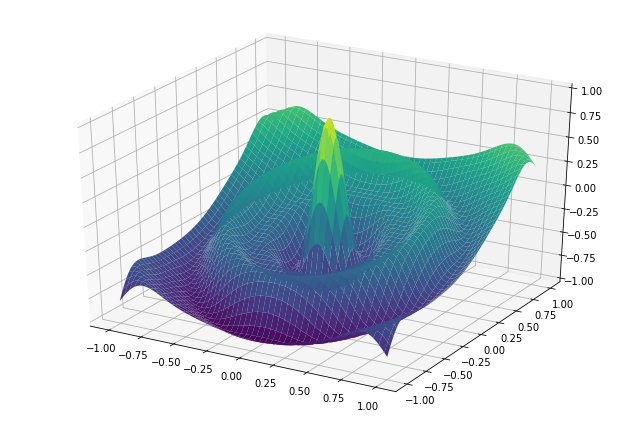

In [ ]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
xx, yy = np.meshgrid(x,y)
zz = function_2d(xx,yy)
surf = ax.plot_surface(xx, yy, zz, cmap='viridis')
surf.set_clim(-1.0, 1.0)
ax.view_init(30,-60)
ax.set_zticks([-1,1])
ax.zaxis.set_major_locator(ticker.MultipleLocator(0.25))
plt.tight_layout()
plt.show()

### Load Data

In [ ]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, dataX_np , dataY_np):
        self.data_X = dataX_np.astype(np.float32)
        self.data_Y = dataY_np.astype(np.float32)
        print(f"My_dataset __init__ received : {self.data_X.shape}, {self.data_Y.shape} ")

    def __getitem__(self, index):
        batch = self.data_X[index]
        target = self.data_Y[index]
        return batch, target
    
    def __len__(self):
        return len(self.data_X)

### Make dataset

In [ ]:
dataset = generate_data(100)

### Train, Valid, Test data split

In [ ]:
x = dataset[:, :2]
y = dataset[:,2:]

# train-temp 분리 (7:3)
x_train, x_temp, y_train, y_temp = train_test_split(x,y,test_size=0.3, shuffle=True)

# temp 에서 validation-test 분리 3 -> 1.5:1.5
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,shuffle=True)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_test.shape)

(7000, 2)
(1500, 2)
(1500, 2)
(1500, 1)


### Model Architecture

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, inp_ = 2, output_ = 1):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(inp_, 56)
        self.fc2 = nn.Linear(56, 28)
        self.fc3 = nn.Linear(28, output_)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)

        return x

### Setting Data Loader

In [ ]:
batch_size = 1000000
train_loader = torch.utils.data.DataLoader(Mydataset(x_train, y_train), batch_size=batch_size, shuffle=False, drop_last = False)
valid_loader = torch.utils.data.DataLoader(Mydataset(x_val, y_val), batch_size=batch_size, shuffle=False, drop_last = False)
test_loader = torch.utils.data.DataLoader(Mydataset(x_test, y_test), batch_size=batch_size, shuffle=False, drop_last = False)

My_dataset __init__ received : (7000, 2), (7000, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 


### Training

In [ ]:
from statistics import mean 
import time

'''
 모델의 학습을 정의하는 함수입니다.
 model, Lossfunction, Optimizer, Scheduler 등을 입력받습니다.
 출력은 train, valdation, test의 loss 리스트로 하였습니다.
 train함수를 사용하면 입력받은 loss와 optimizer, lr scheduler, num_epoch에 따라 model을 학습시킵니다.
'''

def train(model, criterion_, optimizer_, scheduler_, num_epochs=40, first_epoch=1):
    
    train_losses = []
    valid_losses = []
    test_losses = []

    print("----------------------------------------------------------------------------")

    start_time = time.time()
    for epoch in range(first_epoch, first_epoch + num_epochs):
        # train phase
        model.train()
        
        # batch_loss 
        batch_losses = []

        for images, labels in train_loader:
            
            # Move the training data to the GPU
            images = images.to(device)   
            labels = labels.to(device)

            # clear previous gradient computation
            optimizer_.zero_grad()

            # forward propagation
            outputs = model(images)

            # calculate the loss
            loss = criterion_.forward(outputs, labels)
            batch_losses.append(loss.item())

            # backpropagate to compute gradients
            loss.backward()

            # update model weights
            optimizer_.step()

        # Train loss를 저장합니다.
        train_losses.append(mean(batch_losses))

        # validation phase
        # Dropout, BatchNormalization과 같은 layer가 동작하지 않도록 합니다.
        model.eval()

        # We don't need gradients for test, so wrap in 
        # no_grad to save memory
        # 기울기 Gradient를 계산하지 않으며 backpropagation을 하지 않습니다. 
        with torch.no_grad():
            
            correct_test = 0

            for images, labels in valid_loader:

                # Move the training batch to the GPU
                images = images.to(device)
                labels = labels.to(device)

                # forward propagation
                outputs = model(images)

                # calculate the loss
                loss = criterion_(outputs, labels)
                valid_losses.append(loss.item())

            for images, labels in test_loader:
                # Move the training batch to the GPU
                images = images.to(device)
                labels = labels.to(device)

                # forward propagation
                outputs = model(images)

                # calculate the loss
                loss = criterion_(outputs, labels)
                test_losses.append(loss.item())

                # Check Accuracy
                # preds 는 output 중에서 가장 높은 값의 index를 가집니다. 
                _, preds = torch.max(outputs, 1)

                # label이 현재 one hot encoding 형태로 되어있기에 preds를 index로 받아 1인지 확인합니다. 
                # ex) 숫자 2 : label = [0,0,1,0,0,...,0] , label[i][preds] == 1 -> 정답
                for i in range(len(preds)):
                  if labels[i][preds[i]] == 1:
                    correct_test +=1
        
        # 원하는 Epoch마다 결과 출력 
        if (epoch) % 100== 0 :
            curr_time = round(time.time()-start_time)
            train_rec = round(train_losses[-1],5)
            valid_rec = round(valid_losses[-1],5)
            test_rec = round(test_losses[-1],5)
            test_acc = round(100*(correct_test)/len(labels),3)
            print('Epoch', epoch, ' / ',num_epochs)
            print(f"\t [Train loss : {train_rec}]  [Validation loss : {valid_rec}] [Test loss : {test_rec}], [Test Accuracy : {test_acc}%],[curr LR = {scheduler_.get_last_lr()}],[elapsed_time = {curr_time}sec] ")

        # Learning rate Scheduling
        # Scheduler에 따라 learning rate를 조절합니다. 
        scheduler_.step()
        
      
    print(f"\nTrain Ended, total_elapsed_time = {round(time.time()-start_time)} ")
    print("--------------------------------------------------------------------")
    
    # Loss 값 반환
    return train_losses, valid_losses, test_losses

### Model Train

In [ ]:
# Model 1: 결과 날라갔어요ㅜㅜ
model = SimpleMLP()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=10000)

In [ ]:
# Model 2
model = SimpleMLP()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=1000)

----------------------------------------------------------------------------
Epoch 100  /  1000
	 [Train loss : 0.03031]  [Validation loss : 0.03005] [Test loss : 0.0313], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 14sec] 
Epoch 200  /  1000
	 [Train loss : 0.02934]  [Validation loss : 0.0296] [Test loss : 0.03015], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 31sec] 
Epoch 300  /  1000
	 [Train loss : 0.02874]  [Validation loss : 0.029] [Test loss : 0.0294], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 47sec] 
Epoch 400  /  1000
	 [Train loss : 0.02823]  [Validation loss : 0.02849] [Test loss : 0.02887], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 64sec] 
Epoch 500  /  1000
	 [Train loss : 0.02787]  [Validation loss : 0.02813] [Test loss : 0.02851], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 80sec] 
Epoch 600  /  1000
	 [Train loss : 0.02706]  [Validation loss : 0.0273] [Test loss : 0.02764], [Test Accuracy : 0.0%],[curr

In [ ]:
# Model 3
model = SimpleMLP()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=1000)

----------------------------------------------------------------------------
Epoch 100  /  1000
	 [Train loss : 0.02144]  [Validation loss : 0.02079] [Test loss : 0.02175], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 18sec] 
Epoch 200  /  1000
	 [Train loss : 0.01667]  [Validation loss : 0.01619] [Test loss : 0.01666], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 44sec] 
Epoch 300  /  1000
	 [Train loss : 0.01331]  [Validation loss : 0.01326] [Test loss : 0.01368], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 63sec] 
Epoch 400  /  1000
	 [Train loss : 0.01099]  [Validation loss : 0.01099] [Test loss : 0.01154], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 78sec] 
Epoch 500  /  1000
	 [Train loss : 0.01693]  [Validation loss : 0.02622] [Test loss : 0.02731], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 94sec] 
Epoch 600  /  1000
	 [Train loss : 0.00721]  [Validation loss : 0.00753] [Test loss : 0.00762], [Test Accuracy : 0.0%]

## Plot

### Plot loss

In [ ]:
def plot_result(train_loss, val_loss, test_loss):
    plt.figure(figsize=(20,8))
    plt.plot(train_loss, label='Train Loss', linewidth='3')
    plt.plot(val_loss, label='Validation Loss', linewidth='3')
    plt.plot(test_loss, label='Test Loss', linewidth='3')
    plt.grid()
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.legend()
    plt.rc('legend', fontsize=15)
    plt.xlabel('Number of Eopch')
    plt.ylabel('MSE Loss')
    plt.rc('axes', labelsize=17)

### Plot

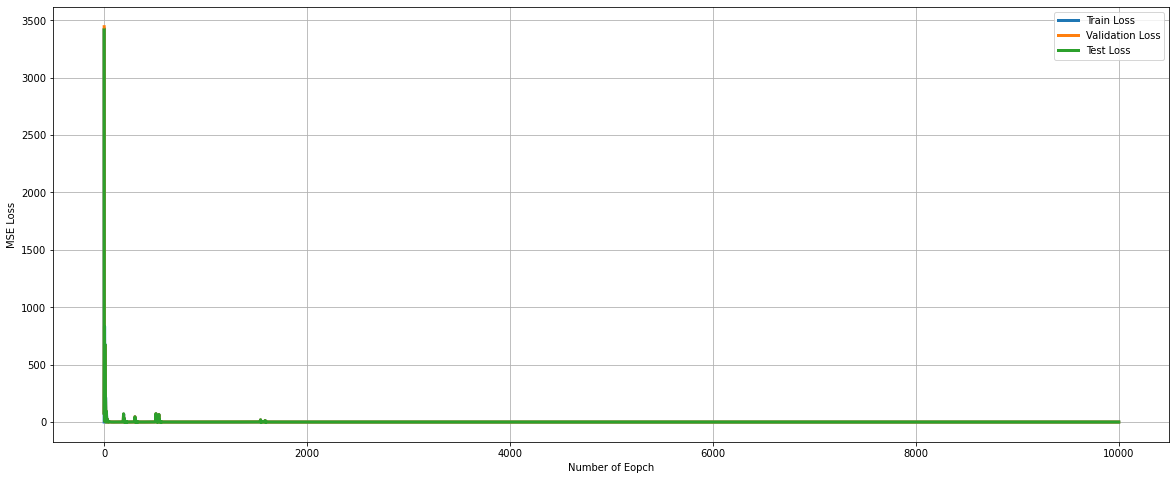

In [ ]:
# Model 1 plot
plot_result(train_losses, valid_losses, test_losses)

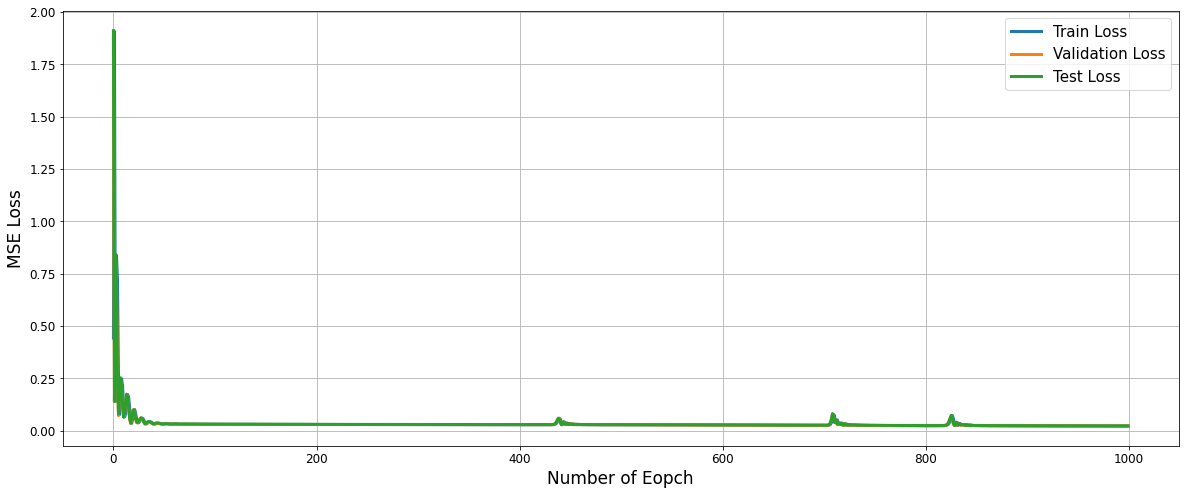

In [ ]:
# Model 2 plot
plot_result(train_losses, valid_losses, test_losses)

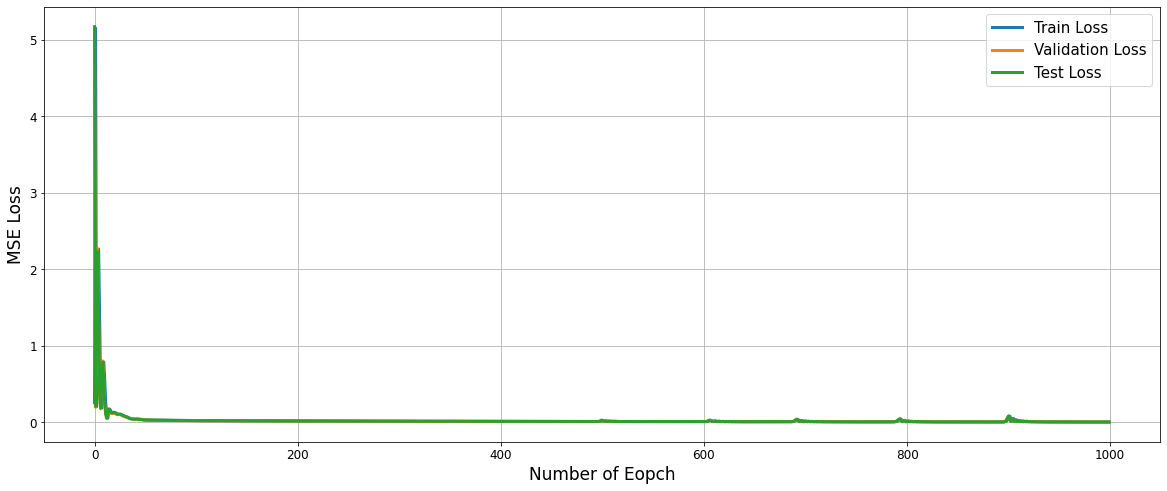

In [ ]:
# Model 3 plot
plot_result(train_losses, valid_losses, test_losses)

### 3D Visualize graph

In [ ]:
def visual_graph(model):
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    xx,yy = np.meshgrid(x,y)
    xx = xx.reshape(-1,1)
    yy = yy.reshape(-1,1)
    inp_np = np.hstack((xx,yy))
    inp_tensor = torch.Tensor(inp_np)
    inp_tensor = inp_tensor.to(device)
    zz = model(inp_tensor)
    pred_output = zz.detach().cpu().numpy()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    xx = xx.reshape(100,100)
    yy = yy.reshape(100,100)
    pred_output = pred_output.reshape(100,100)
    surf = ax.plot_surface(xx, yy, pred_output, cmap='viridis')
    surf.set_clim(-1.0, 1.0)
    ax.view_init(30,-60)
    ax.set_zticks([-1,1])
    ax.zaxis.set_major_locator(ticker.MultipleLocator(0.25))
    plt.tight_layout()
    plt.show()

### Plot 3D Graph

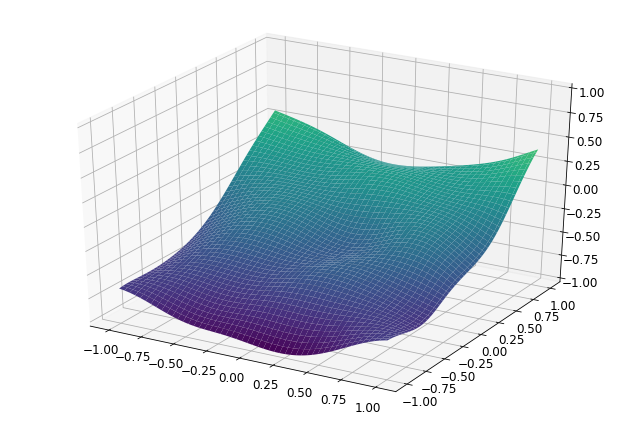

In [ ]:
visual_graph(model)

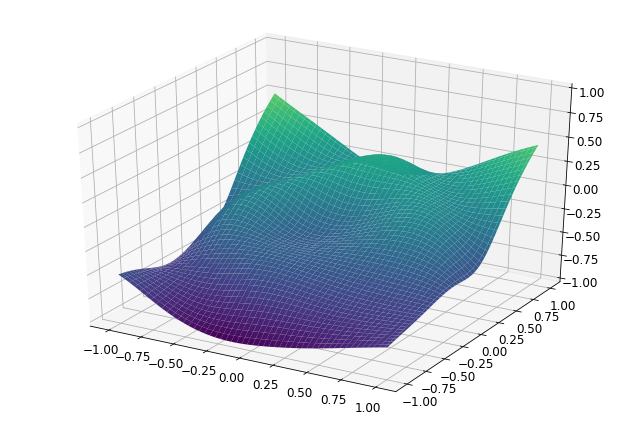

In [ ]:
visual_graph(model)

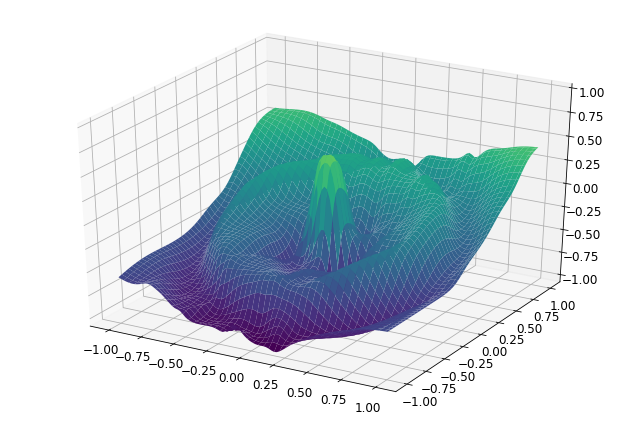

In [ ]:
visual_graph(model)